In [26]:
import numpy as np
from scipy.optimize import fsolve
import xarray as xr
from sympy import Symbol, Eq,exp, sqrt, lambdify
from sympy import exp, sqrt, Max
import matplotlib.pyplot as plt

In [27]:
# %% 


#### Constants and Parameters

In [ ]:
# Constants
epsilon = 0.622  # unitless
A = 2.5e6  # (J/kg)
B = 2.38e3  # (J/(kg K))
A_1 = 8e-4  # (kg/(m·s²·K^3.5))
A_2 = 2.11e-5  # (m²/s) 
T_star = 273.15  # (K)
p_star = 101325  # (kg/(m·s²))
p_n = 1e5  # (kg/(m·s²))
g = 9.80  # (m/s²)
R = 287  # (J/(kg·K))
R_v = 461  # (J/(kg·K))
c_p = 1004  # (J/(kg·K))
p_l = 2e4  # (kg/(m·s²))
alpha_rain = 3500  # (1/s) for rain
alpha_snow = 1500  # (1/s) for snow
c1_rain = 7e5  # (kg/(m³·s)) for rain
c1_snow = 1.4e5  # (kg/(m³·s)) for snow
C_1 = c1_rain
alpha = alpha_rain



In [29]:
# storm invariant parameters from Georgakakos 1986
epsilon_1 = 1.65e-3  # unitless
epsilon_2 = 5e4  # (kg/(m/s²))
epsilon_3 = 1  # (s/m)
epsilon_4 = 5.5e-5  # (m)
gamma = 1  # unitless
beta = 1  # unitless
m = 0  # unitless
delta = 1/3*(1/gamma + 1/gamma**2 + 1/gamma**3)

#### Functions

In [30]:
def w(T,P):
    #mixing ratio
    return epsilon*A_1*(T - 223.15)**3.5/P

def L(T):
    #latent heat of condensation
    return A - B*(T - 273.15)

def e_s(T):
    #saturation vapor pressure
    return A_1*(T - 223.15)**3.5


In [31]:
def v(T_m,T_s_up):
    #average updraft velocity
    v = epsilon_1*np.sqrt(c_p*(T_m - T_s_up))
    return v

def rho_m(T_s,T_t,p_s,p_t):
    #average density inside the cloud
    rho_m = (p_s/(R*T_s) + p_t/(R*T_t))/2
    return rho_m

In [32]:
def f(T_d,p_0,p_s,T_s,rho,v):

    #specific humidity in the ground and cloud base
    w_0 = w(T_d,p_0)
    w_s = w(T_s,p_s)

    return (w_0 - w_s)*rho*v
    


In [33]:
def cloud_heights(T_s,T_t,T_0,p_s,p_t,p_0):
    #cloud depth
    Z_c = R*(T_s + T_t)/(2*g)*np.log(p_s/p_t)
    #cloud base height
    Z_b = R*(T_s + T_0)/(2*g)*np.log(p_0/p_s)

    return Z_c,Z_b

    

In [34]:
def non_dim_numbers(v):
    
    V_p = 4*alpha**epsilon_4*v**m
    N_v = beta*v**(1-m)/(alpha*epsilon_4)
    
    return V_p,N_v

#### Fluxes, state and precipitation

In [35]:
class variables:
    def __init__(self, T_0, T_d, p_0, obs):
        self.T_0 = T_0
        self.T_d = T_d
        self.p_0 = p_0
        self.obs = obs
        self.p_s, self.T_s = self.calculate_cloud_base()
        self.Theta_e = self.calculate_Theta_e(self.T_s,self.p_s)
        
    def calculate_cloud_base(self):
        # cloud base pressure, temperature and specific humidity
        p_s = (1/((self.T_0 - self.T_d)/223.15 + 1))**3.5 * self.p_0
        T_s = (1/((self.T_0 - self.T_d)/223.15 + 1))* self.T_0
        return p_s, T_s
    

    def calculate_Theta_e(self, T_s, p_s):
        # equivalent potential temperature inside the cloud
        Theta_e = T_s*(p_n/p_s)**0.286*np.exp(L(T_s)*w(T_s,p_s)/(c_p*T_s))
        return Theta_e
#--------------------------------------------------------------------------------------------------------------------------
    def calculate_cloud_top(self,T_0,p_0,p_s,Theta_e):
        if self.obs:
            #if they are available from observations, obs=True
            T_t = T_t
            p_t = p_t
        else:
            p_t = Symbol('p_t')
            T_m = Symbol('T_m')
            T_t = Symbol('T_t')


            # solve the two equation system for T_m and p_t
            f1 = Eq(p_t, p_l + (epsilon_2 - p_l) / (1 + epsilon_3 * epsilon_1 *sqrt(Max(1e-7,c_p * (T_m - T_0 / (p_0/(3/4 * p_s + 1/4 * p_t))**0.286)))))

            f2 = Eq(Theta_e,T_m * (p_n / (3/4 * p_s + 1/4 * p_t))**0.286 * exp((A - B * (T_m - 273.15)) #replaced L(T) with the whole expression for fsolve
                                * (epsilon*A_1*abs(T_m - 223.15)**3.5/(3/4 * p_s + 1/4 * p_t))/ (c_p * T_m))) # whole expression here instead of p'

            # Convert the symbolic equations to numerical functions using lambdify
            f1_func = lambdify((p_t, T_m), f1.lhs - f1.rhs, 'numpy')
            f2_func = lambdify((p_t, T_m), f2.lhs - f2.rhs, 'numpy')

            # Define the system of equations for fsolve
            def system(vars):
                p_t_val, T_m_val = vars
                return [f1_func(p_t_val, T_m_val), 
                        f2_func(p_t_val, T_m_val)]

            # Set your initial guesses
            initial_guesses = [20000, 270]  

            # Solve the system using fsolve
            solution = fsolve(system, initial_guesses)

            # Extract the solution
            p_t, T_m = solution

            # solve the non-linear equation for T_t
            f3 = Eq(Theta_e,T_t * (p_n / p_t)**0.286 * exp((A - B * (T_t - 273.15)) * (epsilon*A_1*abs(T_t - 223.15)**3.5/(p_t)) / (c_p * T_t)))
            f3_func = lambdify(T_t, f3.lhs - f3.rhs, 'numpy')
            T_t = fsolve(f3_func, 240)

            # find the ambient air temperature and pressure
            p_s_up = 3/4 * p_s + 1/4 * p_t  #p_s'
            T_s_up = T_0 / (p_0/(p_s_up))**0.286 #T_s'

        return p_t, T_m, T_t,T_s_up, p_s_up
#--------------------------------------------------------------------------------------------------------------------------
    def run(self):
        p_s,T_s = self.p_s,self.T_s
        p_t, T_m, T_t,T_s_up, p_s_up = self.calculate_cloud_top(self.T_0,self.p_0,self.p_s,self.Theta_e)
        return p_s,T_s,p_t, T_m, T_t,T_s_up, p_s_up

In [36]:
class h_out:
    def __init__(self,v,Z_c):
        self.V_p = non_dim_numbers(v)[0]
        self.N_v = non_dim_numbers(v)[1]
        self.Z_c = Z_c
        self.O_b = self.O_b()
        self.O_t = self.O_t()
        
    #cloud bottom outflow
    def O_b(self):
        return (1 + 3/4*self.N_v + self.N_v**2/4 + self.N_v**3/24)/np.exp(self.N_v)

    #cloud top outflow 
    def O_t(self):
        return(1 + 3/4*(gamma*self.N_v) + (gamma*self.N_v)**2/4 + (gamma*self.N_v)**3/24)\
                                        /np.exp(gamma**5*self.N_v**(gamma*self.N_v)) + self.N_v/(4*gamma**4) + 1/gamma**5

    #total outflow
    def h_v(self):
        return self.V_p/(self.Z_c*delta)*(self.O_t + self.O_b)

    def run(self):
        return self.O_b,self.O_t,self.h_v()


In [37]:
class phi:
     
     def __init__(self, T_0, p_0, T_d, Z_b, Z_c,v):
        self.T_0 = T_0
        self.p_0 = p_0
        self.T_d = T_d
        self.Z_b = Z_b
        self.V_p = non_dim_numbers(v)[0]
        self.Z_c = Z_c
        self.N_v = non_dim_numbers(v)[1]
        self.v = v
        self.O_b = h_out(v, Z_c).O_b
        self.T_w = self.solve_Tw()

     def equation_Tw(self, T):
         return T + L(self.T_0)/c_p*(epsilon*A_1*(T - 223.15)**3.5/self.p_0 - w(self.T_d,self.p_0)) - self.T_0
     
     def solve_Tw(self):
         T_w_initial = 290
         return fsolve(self.equation_Tw, T_w_initial)
     
     
     def calculate_phi(self):

        #diffusivity of water vapor in air
        D_AB = A_2*(self.T_0/T_star)**1.94*(p_star/self.p_0)

        #critical diameter for evaporation
        D_c = (1/C_1*4*D_AB/R_v*self.Z_b*(e_s(self.T_w)/self.T_w - e_s(self.T_d)/self.T_0))**(1/3)

        #
        N_D = D_c/(epsilon_4*self.v**m)

        #calculating phi
        if (N_D/self.N_v) >=1:
            phi_t = self.V_p/(self.Z_c*delta)* ((1 - self.N_v/4)*(1 + N_D + N_D**2/2) + N_D**3/8) / np.exp(N_D)
        else:
            phi_t = self.V_p/(self.Z_c*delta)*(self.O_b - 1/24*N_D**3/ np.exp(self.N_v))

        return phi_t

In [38]:
class state:
    def __init__(self,X,T_d,T_0,p_0,Z_c,Z_b,dt,p_s,T_s,rho,v):
        self.X = X
        self.dt = dt
        self.T_d = T_d
        self.T_0 = T_0
        self.p_0 = p_0
        self.Z_c = Z_c
        self.Z_b = Z_b
        self.p_s = p_s
        self.T_s = T_s
        self.rho = rho
        self.v = v
        self.V_p = non_dim_numbers(self.v)[0]
        self.N_v = non_dim_numbers(self.v)[1]

    def state_evol(self):
        X_new = self.X + self.dt*(f(self.T_d,self.p_0,self.p_s,self.T_s,self.rho,self.v) \
                                  - h_out(self.v,self.Z_c).run()[2]*self.X)
        if X_new<0:
         X_new = 0
        return X_new

### Testing the model

In [39]:
measurements = xr.open_mfdataset(r'data\davis-TUD-GV_Green_Village_202407.nc')

In [40]:
var = ['temperature','pressure','humidity','rain_rate']
measurements = measurements[var]
measurements = measurements.dropna(dim='time',how='any')

In [ ]:
#inputs

#temperature on the ground
T_surf_C = measurements['temperature'].values[7000:10000] #[C]
T_surf = T_surf_C + 273.15    # [K]

#pressure
p_surf = measurements['pressure'].values[7000:10000]*100    #[Pa]

#dew point temperature
RH = measurements['humidity'].values[7000:10000]
alpha_T = 17.27*T_surf_C/(T_surf_C + 237.7) + np.log(RH/100) #from http://dx.doi.org/10.31648/ts.5425
T_d_arr = 237.7*alpha_T/(17.27 - alpha_T) + 273.15      #[K]

#state
X = np.zeros(len(T_surf))
X[0] = 10   #initial state in kg/m2
dt= 60      #timestep in s


In [52]:
#loop for finding the precipitation given the T_0 and p
P = np.zeros(len(T_surf))
for i in range(0,len(T_surf)):
    #inputs
    T_0 = T_surf[i]
    p_0 = p_surf[i]
    T_d = T_d_arr[i]

    #meteorological variables
    p_s,T_s,p_t, T_m, T_t,T_s_up, p_s_up = variables(T_0, T_d, p_0, obs=False).run()
    rho = rho_m(T_s,T_t,p_s,p_t)
    v_updr = v(T_m,T_s_up)
    Z_c,Z_b = cloud_heights(T_s,T_t,T_0,p_s,p_t,p_0)
    O_b,O_t,h_v = h_out(v_updr,Z_c).run()   #outflows and sources of water
    
    #precipitation in kg/m2/s
    P[i] = phi(T_0, p_0, T_d, Z_b, Z_c,v_updr).calculate_phi()*X[0] #*X[i] if we are using the updated state

    #state update (now it does not matter)   
    if i<(len(T_surf)-1):
        X[i+1] = state(X[i],T_d,T_0,p_0,Z_c,Z_b,dt,p_s,T_s,rho,v_updr).state_evol()


### Plots and results

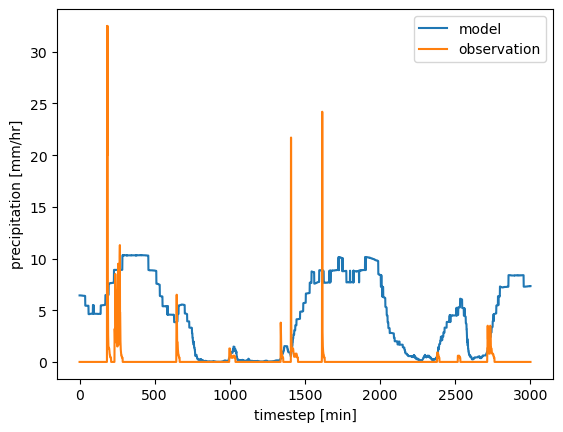

In [58]:
t_step = np.linspace(0,len(P),len(P))

plt.plot(t_step,P*3600,label='model')   #P [kg/m2/s] = P/1000kg/m3 = P/1000 m/s = P* 3600 [mm/hr]
plt.plot(t_step,measurements['rain_rate'].values[7000:10000],label='observation')
plt.xlabel('timestep [min]')
plt.ylabel('precipitation [mm/hr]')
plt.legend()
plt.show()


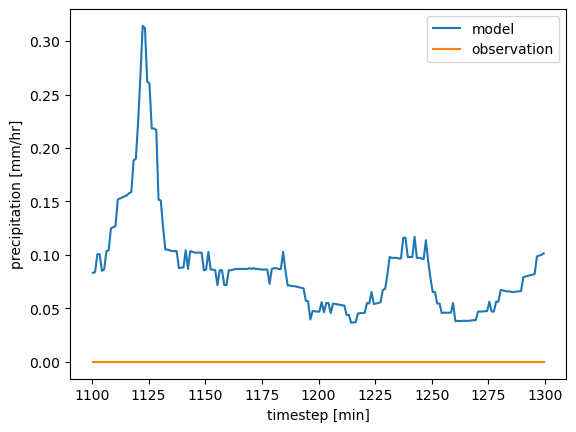

In [59]:
#zooming when no rain is observed

t_step = np.linspace(0,len(P),len(P))
plt.plot(t_step[1100:1300],P[1100:1300]*3600,label='model')
plt.plot(t_step[1100:1300],measurements['rain_rate'].values[8100:8300],label='observation')
plt.legend()
plt.xlabel('timestep [min]')
plt.ylabel('precipitation [mm/hr]')
plt.show()


Text(0, 0.5, 'liquid water [kg/m^2]')

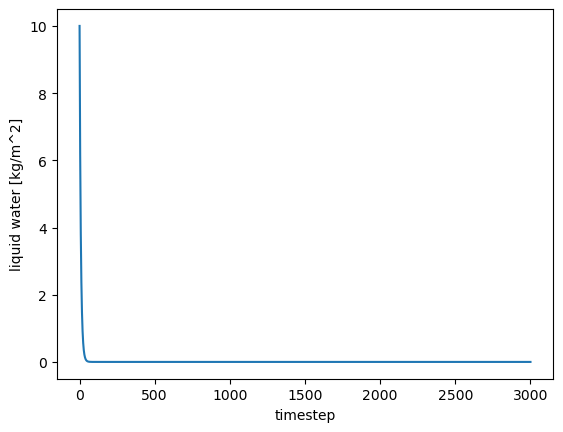

In [60]:
#state evolution

plt.plot(t_step,X)
plt.xlabel('timestep')
plt.ylabel('liquid water [kg/m^2]')